# Lezoine 14

In [ ]:
from liblet import (
    Transition, 
    Automaton, 
    Grammar, 
    Production, 
    Item, 
    Derivation, 
    ProductionGraph, 
    Stack, 
    Queue, 
    StateTransitionGraph, 
    Table, 
    closure, 
    first, 
    prods2table,
    iter2table,
    warn, HASH,
    __version__)

# è suggerito aggiornare all'ultima versione

__version__ 

'1.3.4-alpha'

## Item

Una occhiata a come sono implementati gli *item* nella libreria. Una grammatica d'esempio

In [ ]:
# fig. 3.17, pag. 159 MCD (sostituendo + con -)

G = Grammar.from_string("""
E -> E - T | T
T -> n | ( E )
""")

In [ ]:
# Si costruisce dato rhs e lhs (come le produzioni)

A, α = G.P[0]
item = Item(A, α)
item

E -> •E - T

In [ ]:
# ha un metodo advance che sposta il punto e un metodo
# symbol_after_dot che riporta il simbolo che segue il 
# punto (o None se il punto è oltre la fine del rhs)

for X in α:
    item = item.advance(X)
    print(f'item = {item}, symbol_after_dot = {item.symbol_after_dot()}')

item = E -> E•- T, symbol_after_dot = -
item = E -> E -•T, symbol_after_dot = T
item = E -> E - T•, symbol_after_dot = None


## La ε-chiusura di un insieme di item

Dato un insieme di item, la sua ε-chiusura è ottenuta prendendo la chiusura dell'operazione che aggiunge all'insieme, per ogni item $A\to \alpha • B \beta$, tutti gli item $B\to •\gamma$ dove $B\to \gamma$ è una produzione di $G$.

In [ ]:
@closure
def εclosure(items, G):
    added = set()
    for item in items:
        X = item.symbol_after_dot()
        if X is None: continue
        added |= {Item(X, β) for β in G.alternatives(X)}
    return frozenset(items | added)

In [ ]:
# vediamo come si comporta sul set di item che contiene solo l'item
# ottenuto dalla prima produzione

εclosure({Item(*G.P[0])}, G)

frozenset({E -> •E - T, E -> •T, T -> •( E ), T -> •n})

## Costruzione dell'automa a stati finiti

Definiamo l'automa che riconosce il linguaggio delle parti aperta delle derivazioni di una assegnata grammatica $G$. Tale automa ha per alfabeto $N\cup T$ e per stati *insiemi* di item. 

Il suo stato iniziale $q_0$ è dato dalla ε-chiusura dell'insieme di item derivati da tutte le produzioni che coinvolgono il simbolo iniziale $S$

In [ ]:
def q0(G):
    return εclosure({Item(G.S, β) for β in G.alternatives(G.S)}, G)

In [ ]:
# nel caso della grammatica d'esempio si ha

q0(G)

frozenset({E -> •E - T, E -> •T, T -> •( E ), T -> •n})

La funzione di transizione $\delta$ associa ad ogni insieme di item e simbolo dell'alfabeto l'ε-chiusura dell'insieme ottenuto avanzando col simbolo specificato il punto in ogni item.

In [ ]:
def δ(items, X, G):
    return εclosure({item.advance(X) for item in items if item.advance(X)}, G)

In [ ]:
# vediamo come si comporta sullo stato iniziale
# dato il simbolo '('

δ(q0(G), '(', G)

frozenset({E -> •E - T, E -> •T, T -> •( E ), T -> (•E ), T -> •n})

Prima di procedere, trasformiamo la grammatica in modo da rendere il linguaggio libero da prefissi

In [ ]:
def add_eoi(G):
    return Grammar(G.N | {'S’'}, G.T | {HASH}, G.P + (Production('S’', (G.S, HASH)), ), 'S’')

In [ ]:
# vediamo l'effetto che ha sulla grammatica d'esempio

Gpf = add_eoi(G)
prods2table(Gpf)

L'automa può essere costruito tramite una visita (in ampiezza) degli stati raggiungibili tramite $\delta$; al termine della visita saranno noti tutti gli stati e tutte le *transizioni*. Vengono definiti *finali* gli stati corrispondenti ad insiemi di un solo item in cui il punto è oltre l'ultimo simbolo.

In [ ]:
def compute_lr0_automaton(G):
    
    states = set([q0(G)])
    transitions = []
    q = Queue([q0(G)])
    while q:
        items = q.dequeue()
        for X in G.T | G.N:
            next_items = δ(items, X, G)
            if not next_items: continue
            transitions.append(Transition(items, X, next_items))
            if next_items not in states: 
                states.add(next_items)
                q.enqueue(next_items)

    return Automaton(
        states,
        G.T | G.N,
        transitions,
        q0(G),
        set(state for state in states if len(state) == 1 and first(state).symbol_after_dot() is None)
    )

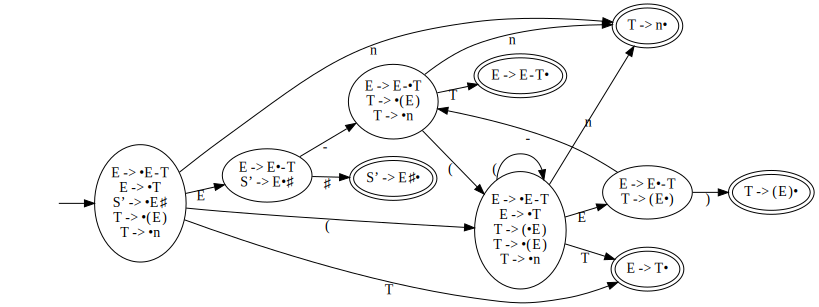

In [ ]:
# visualizziamo l'automa ottenuto dalla grammatica d'esempio

lr0a = compute_lr0_automaton(Gpf)
StateTransitionGraph.from_automaton(lr0a, large_labels = True)

## Parsing con un automa a pila 

Il parser segue l'algoritmo illustrato nella sezione 3.5.2 di MCD.

In [ ]:
def lr0parse(lr0a, text, G):

    rest = text + [HASH, ]
    s = Stack([lr0a.q0])
    steps = []
    
    while True:
        top = s.peek()
        if top in lr0a.F: # REDUCE
            N, α, _ = first(top)
            steps.append(Production(N, α))
            if N == G.S and not rest: return steps
            for _ in α: s.pop()
            nxt = first(lr0a.δ(s.peek(), N))
        else: # SHIFT
            if not rest: 
                warn('Unexpected end of input')
                return None
            token, *rest = rest
            nxt = first(lr0a.δ(top, token))
            if nxt is None: 
                warn('Unexpected token {}'.format(token))
                return None
        s.push(nxt)

In [ ]:
# proviamolo sulla grammatica d'esempio 
# e su 

INPUT = 'n - n - n'.split()

steps = lr0parse(lr0a, INPUT, Gpf)
steps

[T -> n, E -> T, T -> n, E -> E - T, T -> n, E -> E - T, S’ -> E ♯]

L'algoritmo restituisce i passi di una derivazione rightmost, dall'ultimo al primo

In [ ]:
dpf = Derivation(Gpf).rightmost(reversed(steps))
dpf

S’ -> E ♯ -> E - T ♯ -> E - n ♯ -> E - T - n ♯ -> E - n - n ♯ -> T - n - n ♯ -> n - n - n ♯

Possiamo visualizzare l'albero nella grammatica originale $G$ semplicemente trascurando l'ultima produzione (che è quella che produce il simbolo iniziale di $G$ seguito dal terminatore).

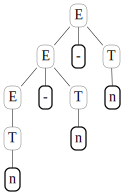

In [ ]:
d = Derivation(G).rightmost(reversed(steps[:-1]))
ProductionGraph(d)

## Conflitti

Purtroppo l'approccio funziona solo per alcune grammatice. Con altre possono presentarsi conflitti *shift/reduce*.

In [ ]:
# ad esempio

Gsr = Grammar.from_string("""
S -> A b | A
A -> a
""")

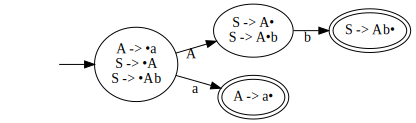

In [ ]:
lr0asr = compute_lr0_automaton(Gsr)
StateTransitionGraph.from_automaton(lr0asr, large_labels = True)

Lo stato $\{S\to A•, S\to A•b\}$ può essere interpretato sia come uno shift verso $\{S\to Ab•\}$ che come un reduce $S\to A$.

Possono inoltre presentarsi conflitti *reduce/reduce*.

In [ ]:
# ad esempio

Grr = Grammar.from_string("""
S -> A | a
A -> a
""")

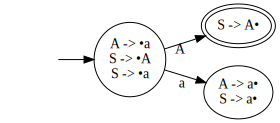

In [ ]:
lr0arr = compute_lr0_automaton(Grr)
StateTransitionGraph.from_automaton(lr0arr, large_labels = True)

In questo caso è lo stato $\{A\to a•, S\to a•\}$ che può essere interpretato come un reduce $A\to a$ o $S\to a$.

# <samp style="color: red;">Per casa</samp> 

## L'automa e le tabelle `GOTO` e `ACTIONS` 

L'automa a stati finiti può essere rappresntato in modo più compatto attraverso due tabelle; dapprima è necessario numerare gli stati (in modo da poter utilizzare numeri interi invece che insiemi di item). 

In [ ]:
states = sorted(map(set, lr0a.N))
iter2table(states)

Quindi si possono usare due tabelle: la tabella `GOTO` che descrive le transizioni

In [ ]:
index_of = states.index

GOTO = Table(2, set)
for frm in states:
    for X in sorted(lr0a.T):
        to = lr0a.δ(frm, X)
        if to: 
            to = first(to)
            GOTO[index_of(frm), X] = index_of(to)
            
GOTO

E una tabella `ACTIONS` per rappresentare le riduzioni (che avvengono solo per gli stati finali)

In [ ]:
ACTIONS = Table(1)

for n, state in enumerate(states):
    if len(state) == 1: 
        A, α, _ = first(state)
        ACTIONS[n] = Production(A, α)

ACTIONS

## Simulazione con le tabelle

Può essere un interessante esecizio scrivere una variante della funzione `lr0parse` che invece di basarsi sul'automa, richieda solo la conoscenza delle tabelle `GOTO` e `ACTIONS` descritte in questa sezione.